# Init

In [1]:
INIT = False
if INIT:
    !pip install dolphins_recognition_challenge

# Libs

In [2]:
import torch
from lib.dataLoader import *
from lib.models import *
from lib.train import train_model
from dolphins_recognition_challenge.datasets import get_dataset, display_batches, ToTensor
from dolphins_recognition_challenge.instance_segmentation.model import train_one_epoch, show_predictions

# Data loaders

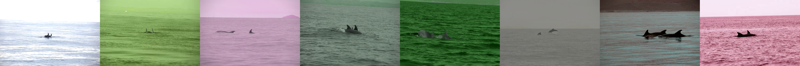

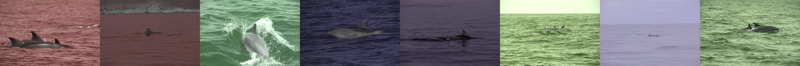

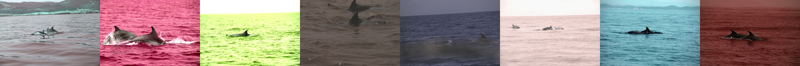

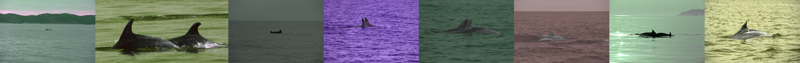

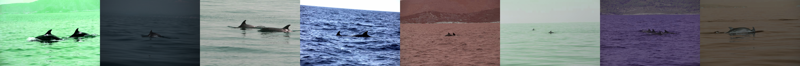

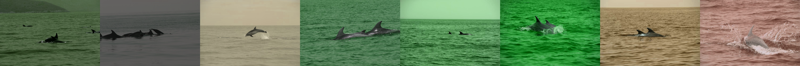

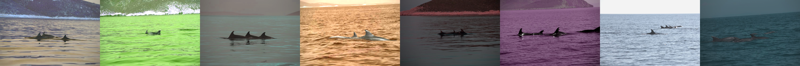

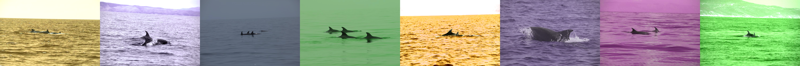

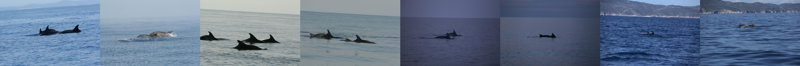

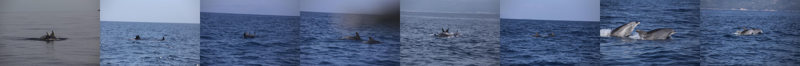

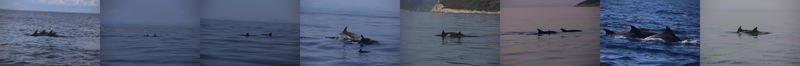

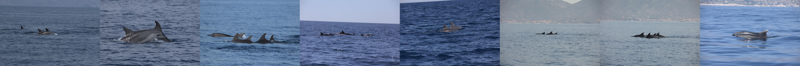

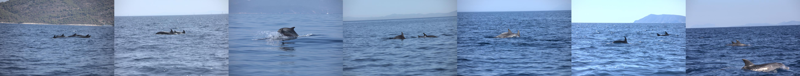

In [3]:
data_loader, data_loader_test = get_data_loader(8)

display_batches(data_loader, n_batches=8)
display_batches(data_loader_test, n_batches=8)

# Setup

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:

# model_maskrcnn_resnet50()
model_block3()

Block3(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# Train

In [6]:
# get the model using our helper function
model = model_maskrcnn_resnet50(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
num_epochs = 1

train_model(1, model, optimizer, lr_scheduler, device, data_loader, data_loader_test)



Epoch #0
Epoch: [0]  [ 0/20]  eta: 0:09:01  lr: 0.000268  loss: 4.6600 (4.6600)  loss_classifier: 0.6462 (0.6462)  loss_box_reg: 0.2841 (0.2841)  loss_mask: 3.7066 (3.7066)  loss_objectness: 0.0084 (0.0084)  loss_rpn_box_reg: 0.0147 (0.0147)  time: 27.0775  data: 1.1449


In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import show_prediction, iou_metric_example, \
    train_one_epoch, show_predictions

for i in range(4):
    iou_test_image = iou_metric_example(model, data_loader_test.dataset[i], 0.5)
    img, _ = data_loader_test.dataset[i]
    print(f"IOU metric for the input image is: {iou_test_image}")
    show_prediction(model, img, width=820)


from dolphins_recognition_challenge.instance_segmentation.model import iou_metric, show_predictions_sorted_by_iou

mean_iou_testset, _ = iou_metric(model, data_loader_test.dataset)

print(f"Mean IOU metric for the test set is: {mean_iou_testset}")